# ctDNA changes as a predictive marker for response (PR/CR/SD/PD) (UMCG/Paul and Hylke, validation at MUG)
To test whether the genomic information helps predict clinical response, we set out to build a model that is able to single out responders (versus non-responders and non-evaluable participants). To this end, we first partitioned the dataset into a training-validation set ($n=...$ participants) and an hold-out test set (the remainder, $n=...$ subjects). 
Below, we report results from five-fold cross-validalation on the training-validation set, and the test set.

To evaluate the model, the following transformation steps were carried out on the set of variant calls from the Avenio platform, after the aforementioned filtering.
1. Point mutations are pooled on a gene granularity by summing over individual variations. 

    a. For either $t_0$ or $t_1$ only results, we directly sum, i.e., 
    $$
    \overline{c}_i^{(\alpha)}(t) \sum_{j\in \text{variations in }i} c_{ij}^{(\alpha)}(t)
    $$ where $c_{ij}^{(\alpha)}(t)$ denotes the mutant concentration (in units of molecules per mL) of variation $j$ (e.g., $j$ = c.973T>C) in gene $i$ (i.e., $i \in \{\text{EGFR}, \text{KRAS},\dots  \}$) at time point $t\in \{t_0, t_1\}$ for patient $\alpha$. Models in which the variant allele frequency, denoted by $x_{ij}^{(\alpha)}(t)$, is used instead of the mutant concentration, are coarse grained in a similar way.
    
    b. For results in which both $t_0$ and $t_1$ information is used, the transformation is applied *before* coarse graining
$$
\overline{f}^{(\alpha)}_i(t_0, t_1) = \sum_{j\in \text{variations in }i} f\left(c_{ij}^{(\alpha)}(t_0), c^{(\alpha)}_{ij}(t_1)\right),
$$
 and similarly for the variant allele frequency.
2. CNV scores are calculated per gene and so no pooling is required. Results considering both $t_0$ and $t_1$ can therefore be directly transformed using $f(u, v)$.
3. After pooling, each genomic feature is made dimensionless by maximum absolute value scaling. The dimensionless numbers lie in the $[-1, 1]$ interval, thereby facilitating a comparison with the clinical variables.
4. The clinical variables age, gender, therapy line, smoking status, histology and presence of lymf-, brain-, adrenal-, liver- and lung metastases were selected for modelling. Each clinical variable is converted into a numeric value by one-hot-encoding, after dichotomising each variable.
5. All genomic values are set to zero when, after filtering, no variants were observed.


A variety of machine learnings models were compared to predict the treatment response (Fig. [?]). All models proved to be equivalent --- within the variation observed in cross-validation --- in terms of the area under the curve of the receiver operating characeristic (AUC ROC). We shall therefore focus on a logistic regression model with $L_2$ regularisation in view of its simple-to-interpret coefficients, and the relative small standard deviation in cross-validation results of the AUC ROC.

In [1]:
from sklearn.linear_model import LogisticRegression

from pipelines import pipeline_Freeman
from transform import combine_tsv_files
from views import view_linear_model_freeman

In [2]:
# Parameters for logistic regression.
logistic_Freeman_parameters = {'estimator__C': 0.1, 'estimator__class_weight': 'balanced'}

## In how many patients did we observe consistent increase/decrease of ctDNA levels? How many patients showed a mixed molecular response?
Figure of Paul
## Can changing levels predict response?

## Do baseline levels correlate with response

In [3]:
# Difference genomic variable.
X_train_t0, y_train = combine_tsv_files(
    "output/train__t0__No. Mutant Molecules per mL.tsv",
    "output/train__t1__CNV Score.tsv",
)

In [4]:
y_train = y_train["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']
pos_label = 'responder (pr+cr)'
y_train = y_train == pos_label

In [5]:
logistic_Freeman = pipeline_Freeman(LogisticRegression)
logistic_Freeman.set_params(**logistic_Freeman_parameters)

Pipeline(memory=None,
         steps=[('clinical_curation',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function clinical_data_curation at 0x7fac6861f670>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('filter_clinical_variables',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function drop_specific_phenoty...
                                                   'lymfmeta', 'brainmeta',
                                                   'adrenalmeta', 'livermeta',
                                                   'lungmeta', 'skeletonmeta',
                                                   'age'])],
                                   verbose=False)),
                ('estimator',
                 LogisticRegression(C=0.1, cla

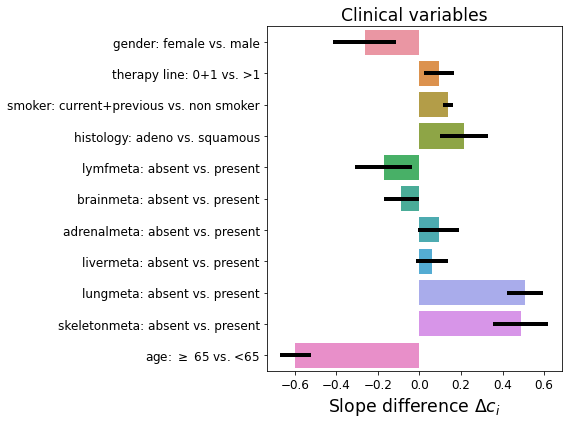

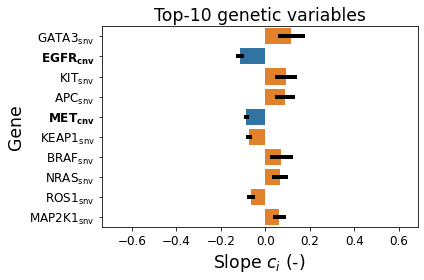

In [7]:
figure_filenames = ("logistic_regression_clinical_freeman", "logistic_regression_genetic_freeman")
view_linear_model_freeman(
    X_train_t0, 
    y_train, 
    logistic_Freeman, 
    filenames=figure_filenames, 
    thresshold=0.1,
)

In [9]:
from sklearn.model_selection import cross_val_score

## Define a cut-off for quantitative change or for baseline levels!
## Use mean of all variants
## Use a delta (T0-T1) of 30% as cut-off
## Use a delta (T0-T1) of 50% as cut-off
## Use a delta (T0-T1) of 80% as cut-off
## Consider only variants with VAF <0.5%
## Consider only variants with VAF <1%
## Use “highest” only
## Use cases with consistent vs mixed changes in levels
## Use all variants including synonymous
## Use only variants excluding synonymous
## Check whether VAF OR mutant molecules/ml is a better predictor